# Sunphotometer Analysis from the 19th May

In [1]:
from __future__ import division
%matplotlib inline
import cPickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg, quad, fixed_quad
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

from IPython.display import Image
from IPython.core.display import HTML 

## Set the Target Time/Date And Wavelength

In [2]:
Image(url= "https://aeronet.gsfc.nasa.gov/cgi-bin/draw_new_oleg_v2?site=Technion_Haifa_IL&year=25&month=4&day=18&product=7&level=2&type=0&if_day=0&if_err=0&inv=1")

In [4]:
TIME = pd.datetime(2017, 5, 19, 12, 45, 0)
WAVELENGTH = 670

# Load the sunphotometer data

## Load the phasefunction

The data is loaded from the sunphotometer logs. Note that new values are interpolated for TIME and WAVELENGTH. I use the "pchip" interpolation method as it is more conservative.

In [6]:
def dateparse(d, t):
    return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

def parsePhaseFunction(path, usecols):
    """Parse the sunphotometer Phase Function data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df, wavelengths

pfn_path = r"../../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.pfn"
df_441, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

In [7]:
series = [pd.Series(d.loc[TIME], name=n) for d, n in zip((df_441, df_674, df_871, df_1020), (441., 674., 871., 1020.))]
df_phf = pd.concat(series, axis=1).T
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_phf.columns), index=df_phf.columns)
df_phf = df_phf.append(new_row).sort_index().interpolate(method="pchip")

In [8]:
df_phf.head()

,0.0,1.71,3.93,6.16,8.39,10.63,12.86,15.1,17.33,19.57,...,160.43,162.67,164.9,167.14,169.37,171.61,173.84,176.07,178.29,180.0
441.0,339.909458,138.185369,48.394747,24.194448,14.972271,10.612474,8.231172,6.738194,5.718091,4.954464,...,0.143112,0.145878,0.149303,0.153707,0.159617,0.167503,0.178245,0.191668,0.201843,0.205030
670.0,206.994286,123.775807,54.380369,29.129960,18.147292,12.495406,9.249450,7.200240,5.835726,4.863694,...,0.175100,0.177759,0.181385,0.186706,0.194636,0.205917,0.221270,0.239286,0.252055,0.255746
674.0,205.411322,123.464860,54.382772,29.175699,18.188202,12.524735,9.268252,7.210675,5.839220,4.863693,...,0.175114,0.177773,0.181409,0.186765,0.194744,0.206082,0.221480,0.239506,0.252254,0.255931
871.0,146.175620,103.779454,53.541490,30.699537,19.788789,13.831875,10.247730,7.919688,6.331940,5.194096,...,0.174939,0.177632,0.181691,0.187992,0.197383,0.210434,0.227227,0.245419,0.257409,0.260614
1020.0,115.647862,89.179645,50.897350,30.634768,20.305881,14.460886,10.834684,8.431603,6.758010,5.534278,...,0.168835,0.171462,0.175624,0.182261,0.192207,0.205900,0.223144,0.241236,0.252813,0.255855


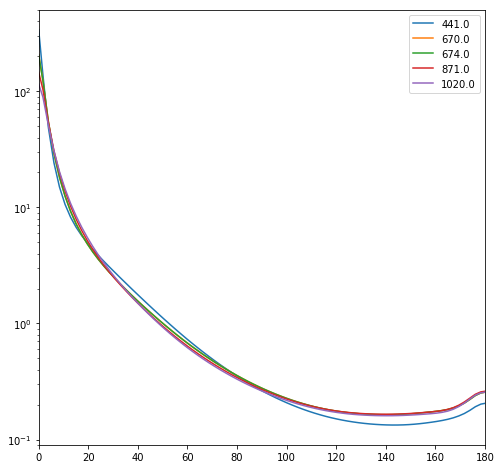

In [9]:
df_phf.T.plot(logy=True)

## Load the Single-Scatter Albedo

In [10]:
def parseSSA(path):
    """Parse the sunphotometer SSA data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 7))
    )

    wavelengths = [float(i[3:-2]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

ssa_path = r"../../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.ssa"

df_ssa = parseSSA(ssa_path)

### Interpolate by wavelength

In [11]:
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_ssa.T.columns), index=df_ssa.T.columns)

df_ssa = df_ssa.T.append(new_row).sort_index().interpolate(method="pchip")

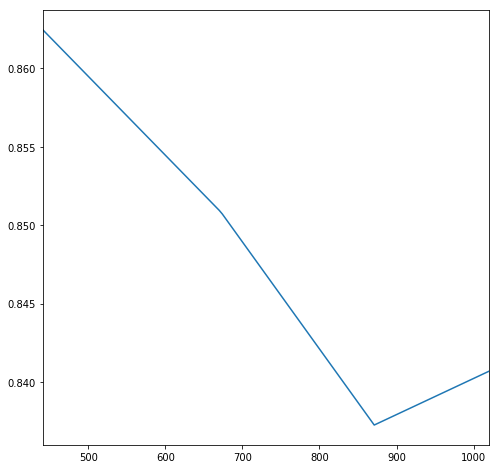

In [12]:
df_ssa.T.loc[TIME].T.plot()

In [13]:
df_ssa.loc[WAVELENGTH][TIME]

0.85094748385794561

## Load the AOD

In [15]:
def parseAOD(path):
    """Parse the sunphotometer AOD data."""

    df = pd.read_csv(
        path,
        skiprows=4,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 14))
    )

    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

aod_path = r"../../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.lev15"

df_aod = parseAOD(aod_path)

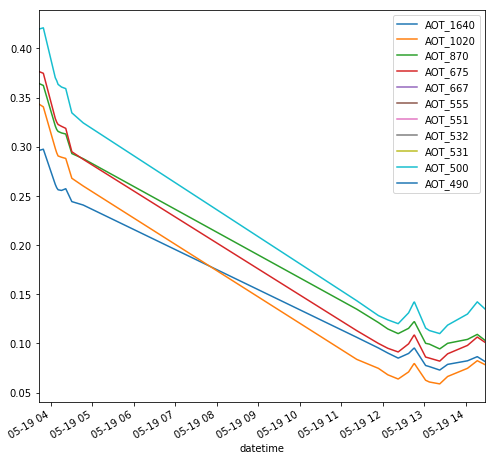

In [16]:
df_aod.plot()

In [17]:
df_aod.AOT_675[TIME]

0.10834902412946396

# Calculate the Legndre Coefficients

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

# Calculate the Legendre Coefficients

## Use quadrature integration

Note I am using linear interpolation. The reason is that higher order interpolation creates artifacts, probably due to the high directionality of the phase function.

In [18]:
COFFES_NUM = 300

In [19]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_phf.loc[WAVELENGTH].values[::-1]

phase_interp = interp1d(mu, phase, kind=1)

def func(x, l, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

In [20]:
coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    #coeffs_quad.append(quad(func, -1, 1, args=(l, lg,), limit=1000)[0])
    #coeffs_quad.append(fixed_quad(func, -1, 1, args=(l, lg,), n=50000)[0])
    coeffs_quad.append(quadrature(func, -1, 1, args=(l, lg,), maxiter=1000)[0])

A Jupyter Widget

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.023479e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.698717e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.354532e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.983464e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.597782e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.690276e-04
  AccuracyWarning)


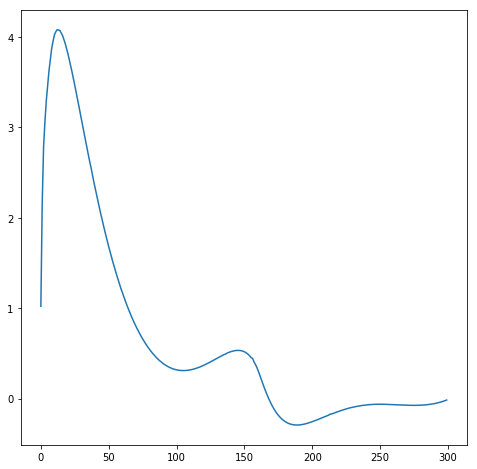

In [21]:
plt.plot(coeffs_quad)

## Reconstruct the Phase function by the Legndre coefficients

In [22]:
mu_new = np.linspace(-1, 1, 3000)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff
coeffs_quad_ = coeffs_quad[:]
coeffs_quad_[0] = 1.
phase_gauss_ = 0
for l, coeff in enumerate(coeffs_quad_):
    phase_gauss_ += legendre(l)(mu_new) * coeff

(0.95, 1)

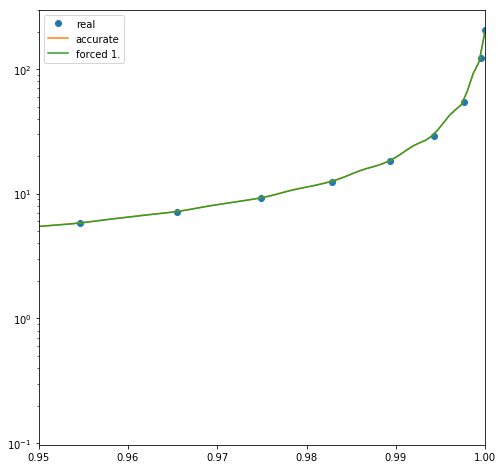

In [23]:
plt.semilogy(mu, phase, "o", label="real")
plt.semilogy(mu_new, phase_gauss, "-", label="accurate")
plt.semilogy(mu_new, phase_gauss_, label="forced 1.")
plt.legend()
plt.xlim(0.95, 1)

### Save the result as pickle

In [36]:
with open("particles_{}_{}.pkl".format(TIME.strftime("%Y_%m_%d_%H_%M_%S"), WAVELENGTH), "wb") as f:
    pickle.dump(
        dict(
            ssa=df_ssa.loc[WAVELENGTH][TIME],
            legend=coeffs_quad_,
            aod=df_aod.AOT_675[TIME],
            aod_height=2.5
        ),
        f
    )

### Save the result

In [58]:
header = """! Mie scattering table vs. effective radius (LWC=1 g/m^3)
  0.{}    0.{}    0.000  wavelength range and averaging step (micron)
   2    1.450    1.450  number       starting       ending REAL refractive index
   2    0.000    0.000  number       starting       ending IMAGINARY refractive index
   2    0.100    0.100  number       starting       ending effective radius
   2    0.500    0.500  number       starting       ending effective variance
 """.format(WAVELENGTH, WAVELENGTH)
line_template = " 1.450 -.000     1.000    %f   0.5000   0.1000     %d  Phase function: Re{m}  Im{m}   Ext  Alb  Veff  Reff  Nleg\n"

In [59]:
with open(TIME.strftime("aerosol{}dredvedm__%Y%m%d_%H%M.scat".format(WAVELENGTH)), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (df_ssa.loc[WAVELENGTH][TIME], len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")